In [63]:
import pandas as pd
import numpy as np
import datetime as dt

## Preparing the Data

In [64]:
df = pd.read_csv("datasets/hour.csv")

In [65]:
df.shape

(17379, 17)

In [66]:
import seaborn as sns

In [67]:
df.isna().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [68]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['dtime'] = df.apply(lambda row: dt.datetime(year=row['dteday'].year, month=row['dteday'].month,
                                                      day=row['dteday'].day, hour=row['hr']), axis=1)



In [69]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dtime
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00


In [70]:
df.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtime         datetime64[ns]
dtype: object

In [71]:
df.rename(columns={'dteday': 'dte', 'season':'season_num', 'cnt':'total'}, inplace=True)

In [72]:
df['season_name'] = df['season_num'].apply(lambda x: 
                                           'winter' if x == 1 else 
                                           'spring' if x == 2 else 
                                           'summer' if x == 3 else 
                                           'fall')

#### Unnormalizing existing weather data, adding more from open-meteo.com Historical Weather API


temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

Adding Precipitation, Cloud Cover, Windspeed, Temperature


In [73]:
df['humidity'] = df['hum'] * 100
df.drop(['temp', 'atemp', 'hum','windspeed'], axis=1, inplace=True)

### Create Weather API module


In [74]:
import requests
import json 

class WeatherData():


    def __init__(self):

        self.base_url = "https://archive-api.open-meteo.com/v1/archive"
        self.coordinates = '?latitude=38.8951&longitude=-77.0364'
        self.timezone = '&timezone=America%2FNew_York'

    def get_weather(self, start_date = '2011-01-01', end_date = '2012-12-31', 
                        hourly_list=['precipitation,cloudcover,windspeed_10m','temperature_2m']):
            
            timeframe = ('&start_date='+ start_date + '&end_date=' + end_date)
            hourly = ('&hourly=' + (",".join(hourly_list)))
            api_url = (self.base_url + self.coordinates + timeframe + hourly + self.timezone)
            resp = requests.get(api_url)
            weather_data = resp.json()
            
            return weather_data
    
    def concat_to_df(self,df,my_weather):
        # Extract the data
        for measure in my_weather['hourly']:

            hourly_measure = my_weather['hourly'][measure]
            unit_of_measure = my_weather['hourly_units'][measure]

            # Iterate over the rows in the DataFrame
            for index, row in df.iterrows():
                custom_index = index 
                measure_value = hourly_measure[custom_index]

                # Assign the value to the respective row in the DataFrame
                name = measure + '_' + unit_of_measure
                df.at[index, name] = measure_value

            
dc_weather = WeatherData()
my_weather = dc_weather.get_weather()

In [75]:
# Extract the hourly data from the JSON object
hourly_data = my_weather['hourly']

df_api = pd.DataFrame(hourly_data)

In [76]:
df_api['dtime'] = pd.to_datetime(df_api['time'])
df_api['temperature_2m'] = round(df_api['temperature_2m'])
df_api.rename(columns={'temperature_2m': 'temperature', 'windspeed_10m': 'windspeed'}, inplace=True)
df.rename(columns={'season_name': 'season', 'cnt':'total'})
df_api.drop('time',axis=1, inplace=True)
df.drop(['dte', 'mnth', 'hr', 'yr','instant'], axis=1, inplace=True)

#### Merging new weatherdata with exisiting

In [77]:
final_df = df.merge(df_api, on='dtime', how='left')
df_complete = final_df.copy()

In [78]:
df.dtypes

season_num              int64
holiday                 int64
weekday                 int64
workingday              int64
weathersit              int64
casual                  int64
registered              int64
total                   int64
dtime          datetime64[ns]
season_name            object
humidity              float64
dtype: object

In [79]:
df_complete.head()

,season_num,holiday,weekday,workingday,weathersit,casual,registered,total,dtime,season_name,humidity,precipitation,cloudcover,windspeed,temperature
0,1,0,6,0,1,3,13,16,2011-01-01 00:00:00,winter,81.0,0.0,20,8.3,2.0
1,1,0,6,0,1,8,32,40,2011-01-01 01:00:00,winter,80.0,0.0,7,8.8,2.0
2,1,0,6,0,1,5,27,32,2011-01-01 02:00:00,winter,80.0,0.0,8,8.4,2.0
3,1,0,6,0,1,3,10,13,2011-01-01 03:00:00,winter,75.0,0.0,0,8.3,1.0
4,1,0,6,0,1,0,1,1,2011-01-01 04:00:00,winter,75.0,0.0,30,9.3,1.0


In [80]:
df_complete['cloud_category'] = df_complete['cloudcover'].apply(lambda x: 
                                          'No Clouds' if x <= 10 else
                                          'Low Clouds' if x <= 30 else
                                          'Medium Clouds' if x <= 50 else
                                          'Very Cloudy' if x <= 85 else
                                          'Fully Covered' )

In [81]:
df_complete['wind_category'] = df_complete['windspeed'].apply(lambda x: 'low' if x <= 20 else 
                                                     'medium' if x <= 30 else 
                                                     'high')

In [82]:
df_complete['temperature_bins'] = pd.cut(df_complete['temperature'], bins=3, labels=('Cold','Warm','Hot'))
df_complete['humidity_bins'] = pd.cut(df_complete['humidity'], bins=3, labels=('Low','Medium','High'))
df_complete['precipitation_bins'] = pd.cut(df_complete['precipitation'], bins=3, labels=('Low','Medium','High'))

In [83]:
df_complete = df_complete[['dtime','season_name','weekday','workingday','holiday','total','casual',
         'registered','temperature', 'temperature_bins','precipitation', 'precipitation_bins','humidity', 'humidity_bins', 'windspeed','wind_category','cloudcover','cloud_category']]

In [84]:
df_complete.dtypes

dtime                 datetime64[ns]
season_name                   object
weekday                        int64
workingday                     int64
holiday                        int64
total                          int64
casual                         int64
registered                     int64
temperature                  float64
temperature_bins            category
precipitation                float64
precipitation_bins          category
humidity                     float64
humidity_bins               category
windspeed                    float64
wind_category                 object
cloudcover                     int64
cloud_category                object
dtype: object

In [85]:
df_complete['season_name'] = df_complete['season_name'].astype('category')
df_complete['temperature'] = df_complete['temperature'].astype('int')
df_complete['humidity'] = df_complete['humidity'].astype('int')
df_complete['windspeed'] = df_complete['windspeed'].astype('int')
df_complete['wind_category'] = df_complete['wind_category'].astype('category')
df_complete['cloudcover'] = df_complete['cloudcover'].astype('int')
df_complete['cloud_category'] = df_complete['cloud_category'].astype('category')
df_complete['dtime'] = pd.to_datetime(df_complete['dtime'])

In [86]:
df_complete.dtypes

dtime                 datetime64[ns]
season_name                 category
weekday                        int64
workingday                     int64
holiday                        int64
total                          int64
casual                         int64
registered                     int64
temperature                    int64
temperature_bins            category
precipitation                float64
precipitation_bins          category
humidity                       int64
humidity_bins               category
windspeed                      int64
wind_category               category
cloudcover                     int64
cloud_category              category
dtype: object

In [87]:
df_complete['wind_category'].value_counts()

low       16633
medium      705
high         41
Name: wind_category, dtype: int64

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
corr_matrix = df_complete.corr()
display(corr_matrix)

,weekday,workingday,holiday,total,casual,registered,temperature,precipitation,humidity,windspeed,cloudcover
weekday,1.000000,0.035955,-0.102088,0.026900,0.032721,0.021578,-0.001986,-0.000239,-0.037313,0.023780,-0.022685
workingday,0.035955,1.000000,-0.252471,0.030284,-0.300942,0.134326,0.053202,0.008495,0.015693,-0.007449,0.016195
holiday,-0.102088,-0.252471,1.000000,-0.030927,0.031564,-0.047345,-0.023588,-0.003755,-0.010665,0.009640,-0.018282
total,0.026900,0.030284,-0.030927,1.000000,0.694564,0.972151,0.410885,-0.059560,-0.323104,-0.086203,-0.048161
casual,0.032721,-0.300942,0.031564,0.694564,1.000000,0.506618,0.473846,-0.044877,-0.347124,-0.051749,-0.043106
registered,0.021578,0.134326,-0.047345,0.972151,0.506618,1.000000,0.338051,-0.056758,-0.274133,-0.086449,-0.043675
temperature,-0.001986,0.053202,-0.023588,0.410885,0.473846,0.338051,1.000000,0.049823,-0.043288,-0.164960,0.006452
precipitation,-0.000239,0.008495,-0.003755,-0.059560,-0.044877,-0.056758,0.049823,1.000000,0.213802,0.091544,0.270807
humidity,-0.037313,0.015693,-0.010665,-0.323104,-0.347124,-0.274133,-0.043288,0.213802,1.000000,-0.201671,0.397561
windspeed,0.023780,-0.007449,0.009640,-0.086203,-0.051749,-0.086449,-0.164960,0.091544,-0.201671,1.000000,0.052907


<AxesSubplot:>

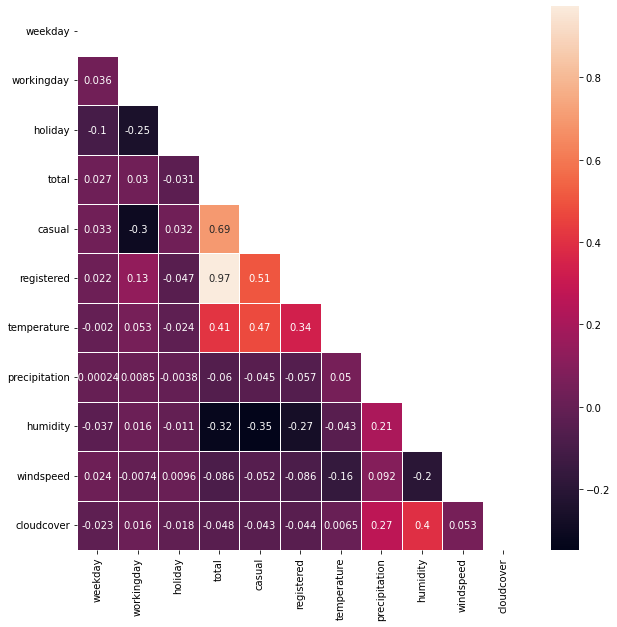

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, linewidths=.5, ax=ax)

In [91]:
df_complete['weekday'].value_counts()

6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: weekday, dtype: int64

In [92]:

# Assuming df_complete contains the 'weekday' column with values 0-6 representing weekdays.

# Perform one-hot encoding using pandas get_dummies function
df_encoded = pd.get_dummies(df_complete, columns=['weekday'], prefix='day', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
print(df_encoded.head())

                dtime season_name  workingday  holiday  total  casual  \
0 2011-01-01 00:00:00      winter           0        0     16       3   
1 2011-01-01 01:00:00      winter           0        0     40       8   
2 2011-01-01 02:00:00      winter           0        0     32       5   
3 2011-01-01 03:00:00      winter           0        0     13       3   
4 2011-01-01 04:00:00      winter           0        0      1       0   

   registered  temperature temperature_bins  precipitation  ... wind_category  \
0          13            2             Cold            0.0  ...           low   
1          32            2             Cold            0.0  ...           low   
2          27            2             Cold            0.0  ...           low   
3          10            1             Cold            0.0  ...           low   
4           1            1             Cold            0.0  ...           low   

   cloudcover cloud_category  day_0 day_1  day_2 day_3  day_4  day_5  day_

In [101]:
df_encoded['rainy'] = df_encoded['precipitation'].apply(lambda x: 'yes' if x > 0.0 else 'no')

In [102]:
df_encoded['rainy'].value_counts()

no     15175
yes     2204
Name: rainy, dtype: int64

In [215]:
df_encoded = pd.get_dummies(df_encoded, columns=['rainy'], prefix='rainy', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
df_encoded.head()

KeyError: "None of [Index(['rainy'], dtype='object')] are in the [columns]"

In [217]:
df_encoded = pd.get_dummies(df_encoded, columns=['holiday'], prefix='holiday', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
df_encoded.head()

,dtime,season_name,workingday,total,casual,registered,temperature,temperature_bins,precipitation,precipitation_bins,...,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes,holiday_0,holiday_1
0,2011-01-01 00:00:00,winter,0,16,3,13,2,Cold,0.0,Low,...,0,0,0,0,0,1,1,0,1,0
1,2011-01-01 01:00:00,winter,0,40,8,32,2,Cold,0.0,Low,...,0,0,0,0,0,1,1,0,1,0
2,2011-01-01 02:00:00,winter,0,32,5,27,2,Cold,0.0,Low,...,0,0,0,0,0,1,1,0,1,0
3,2011-01-01 03:00:00,winter,0,13,3,10,1,Cold,0.0,Low,...,0,0,0,0,0,1,1,0,1,0
4,2011-01-01 04:00:00,winter,0,1,0,1,1,Cold,0.0,Low,...,0,0,0,0,0,1,1,0,1,0


In [216]:
df_encoded

,dtime,season_name,workingday,holiday,total,casual,registered,temperature,temperature_bins,precipitation,...,cloud_category,day_0,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes
0,2011-01-01 00:00:00,winter,0,0,16,3,13,2,Cold,0.0,...,Low Clouds,0,0,0,0,0,0,1,1,0
1,2011-01-01 01:00:00,winter,0,0,40,8,32,2,Cold,0.0,...,No Clouds,0,0,0,0,0,0,1,1,0
2,2011-01-01 02:00:00,winter,0,0,32,5,27,2,Cold,0.0,...,No Clouds,0,0,0,0,0,0,1,1,0
3,2011-01-01 03:00:00,winter,0,0,13,3,10,1,Cold,0.0,...,No Clouds,0,0,0,0,0,0,1,1,0
4,2011-01-01 04:00:00,winter,0,0,1,0,1,1,Cold,0.0,...,Low Clouds,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,winter,1,0,119,11,108,4,Cold,0.0,...,Fully Covered,0,1,0,0,0,0,0,1,0
17375,2012-12-31 20:00:00,winter,1,0,89,8,81,4,Cold,0.0,...,Very Cloudy,0,1,0,0,0,0,0,1,0
17376,2012-12-31 21:00:00,winter,1,0,90,7,83,4,Cold,0.0,...,Very Cloudy,0,1,0,0,0,0,0,1,0
17377,2012-12-31 22:00:00,winter,1,0,61,13,48,3,Cold,0.0,...,Very Cloudy,0,1,0,0,0,0,0,1,0


### Linear Regression

In [104]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [105]:
df_encoded

,dtime,season_name,workingday,holiday,total,casual,registered,temperature,temperature_bins,precipitation,...,cloud_category,day_0,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes
0,2011-01-01 00:00:00,winter,0,0,16,3,13,2,Cold,0.0,...,Low Clouds,0,0,0,0,0,0,1,1,0
1,2011-01-01 01:00:00,winter,0,0,40,8,32,2,Cold,0.0,...,No Clouds,0,0,0,0,0,0,1,1,0
2,2011-01-01 02:00:00,winter,0,0,32,5,27,2,Cold,0.0,...,No Clouds,0,0,0,0,0,0,1,1,0
3,2011-01-01 03:00:00,winter,0,0,13,3,10,1,Cold,0.0,...,No Clouds,0,0,0,0,0,0,1,1,0
4,2011-01-01 04:00:00,winter,0,0,1,0,1,1,Cold,0.0,...,Low Clouds,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,winter,1,0,119,11,108,4,Cold,0.0,...,Fully Covered,0,1,0,0,0,0,0,1,0
17375,2012-12-31 20:00:00,winter,1,0,89,8,81,4,Cold,0.0,...,Very Cloudy,0,1,0,0,0,0,0,1,0
17376,2012-12-31 21:00:00,winter,1,0,90,7,83,4,Cold,0.0,...,Very Cloudy,0,1,0,0,0,0,0,1,0
17377,2012-12-31 22:00:00,winter,1,0,61,13,48,3,Cold,0.0,...,Very Cloudy,0,1,0,0,0,0,0,1,0


In [263]:
X = df_encoded[['temperature','windspeed','rainy_no', 'rainy_yes', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'holiday_1']]
y = df_encoded['casual'] 


In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [265]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [266]:
y_pred = model.predict(X_test)

In [267]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 26.77
Mean Squared Error (MSE): 1530.66
Root Mean Squared Error (RMSE): 39.12
R-squared (R2): 0.33


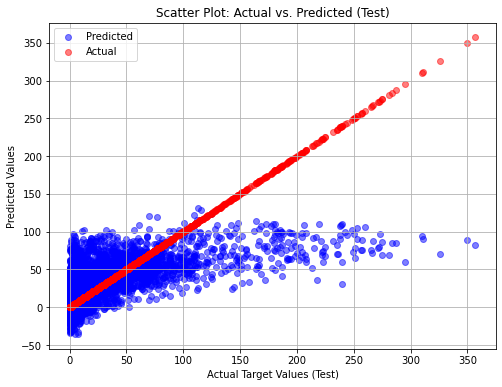

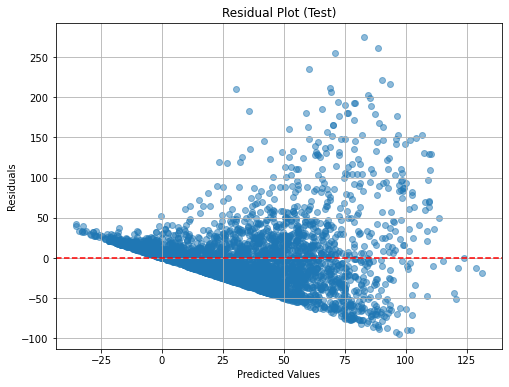

In [111]:
# Scatter plot
# Scatter plot with different colors for actual and predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)  # Predicted values in blue
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)  # Actual target values in red
plt.xlabel('Actual Target Values (Test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test)')
plt.grid(True)
plt.show()

In [112]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [113]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,rainy_no,11.76
3,rainy_yes,2.73
9,day_6,1.71
4,day_1,1.70
7,day_4,1.70
5,day_2,1.69
6,day_3,1.69
8,day_5,1.69
0,temperature,1.03
1,windspeed,1.03


### Polynomial


In [218]:
from sklearn.preprocessing import PolynomialFeatures

In [219]:
X = df_encoded[['temperature','windspeed', 'rainy_yes', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'holiday_1']]
y = df_encoded['total'] 

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [221]:
from sklearn.preprocessing import PolynomialFeatures
degree = 3 # Choose the degree of the polynomial (you can adjust this value)
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [222]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [223]:
y_pred = model.predict(X_test_poly)

In [224]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 119.04
Mean Squared Error (MSE): 25191.22
Root Mean Squared Error (RMSE): 158.72
R-squared (R2): 0.20


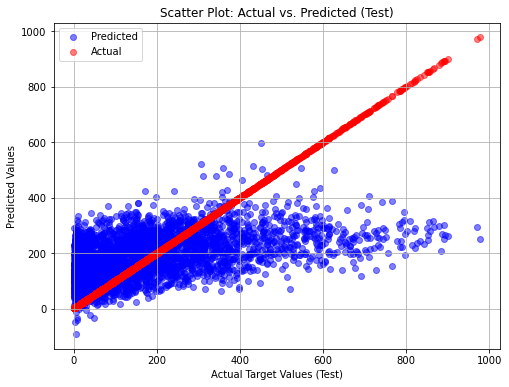

In [225]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)  # Predicted values in blue
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)  # Actual target values in red
plt.xlabel('Actual Target Values (Test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()


In [226]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [254]:
X = df_encoded[['temperature','windspeed', 'rainy_yes', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'holiday_1']]
y = df_encoded['casual'] 


In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [256]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [257]:
svr_model = SVR(C= 10.0, epsilon= 0.5, kernel= 'rbf')  # You can experiment with different kernels and hyperparameters
svr_model.fit(X_train_scaled, y_train)

SVR(C=10.0, epsilon=0.5)

In [258]:
# param_grid = {
#     'C': [0.1, 1.0, 10.0],  # Penalty parameter C of the error term
#     'kernel': ['linear', 'rbf'],  # Kernel type to use
#     'epsilon': [0.01, 0.1, 0.5]  # Epsilon in the epsilon-SVR model
# }

In [259]:
# # Initialize GridSearchCV with the SVR model and parameter grid
# grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# # Perform the grid search on the training data
# grid_search.fit(X_train_scaled, y_train)

# # Get the best hyperparameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Make predictions using the best model
# y_pred = best_model.predict(X_test_scaled)

# # Evaluate the model's performance
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# # Print the best hyperparameters and metrics 
# print("Best Hyperparameters:", best_params)
# print(f'Mean Absolute Error (MAE): {mae:.2f}')
# print(f'Mean Squared Error (MSE): {mse:.2f}')
# print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
# print(f'R-squared (R2): {r2:.2f}')

#### Gridsearch Results

- Best Hyperparameters: {'C': 10.0, 'epsilon': 0.5, 'kernel': 'rbf'}
- Mean Absolute Error (MAE): 22.27
- Mean Squared Error (MSE): 1431.38
- Root Mean Squared Error (RMSE): 37.83
- R-squared (R2): 0.38

In [260]:
y_pred = svr_model.predict(X_test_scaled)

In [261]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 22.27
Mean Squared Error (MSE): 1415.15
Root Mean Squared Error (RMSE): 37.62
R-squared (R2): 0.38


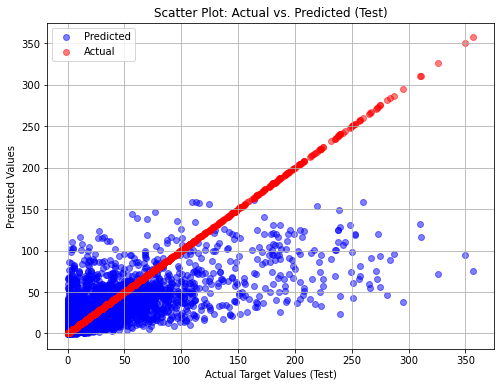

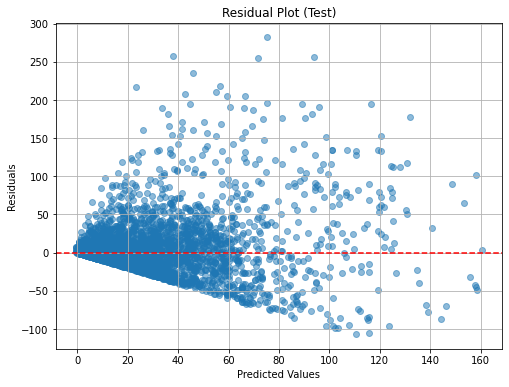

In [262]:
# Scatter plot
# Scatter plot with different colors for actual and predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)  # Predicted values in blue
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)  # Actual target values in red
plt.xlabel('Actual Target Values (Test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test)')
plt.grid(True)
plt.show()